# Conducting research to solve the NLP test task

In this notebook we prepare the Named entity recognition (NER) model for use.

# Base

The task of NER is to highlight the spans of entities in the text.

The scenario of this task is to identify in the text 2 entities: `обеспечение исполнения контракта` или `обеспечение гарантийных обязательств`.

## Example

<div>
<img src="images/ner_example.jpg" width="800"/>
</div>

The solution of the problem was reduced to choosing the most suitable model (`BERT`, `BERT + LSTM`, `spaCy` or another).

As a result, `spaCy` was chosen without pretrained models.

## Pipeline

![pipeline](images/spacy_pipeline.png)

# Setup

In [1]:
pip install -r requirements.txt

You should consider upgrading via the 'C:\Users\maks_\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import json
import pandas as pd
import locale

# Data preparation

In [3]:
train_url = 'https://raw.githubusercontent.com/sonodug/NER/main/data/train.json'
test_url = 'https://raw.githubusercontent.com/sonodug/NER/main/data/test.json'

train_df  = pd.read_json(train_url)
test_df = pd.read_json(test_url)

In [4]:
train_df.head()

,id,text,label,extracted_part
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить обесп...
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...


In [5]:
test_df.head()

,id,text,label
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта


In [6]:
len(train_df["text"].values)

1799

In [7]:
len(test_df["text"].values)

318

In [8]:
locale.getpreferredencoding = lambda: "UTF-8"

# NER with spaCy's pretrained model 

In [9]:
import spacy
from spacy import displacy

In [10]:
!python -m spacy download ru_core_news_sm

     ---------------------------------------- 15.3/15.3 MB 4.6 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


You should consider upgrading via the 'C:\Users\maks_\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [11]:
# Load and initialize a blank spaCy model
nlp=spacy.blank("ru")
nlp.add_pipe('ner')
nlp.begin_training()
ner = nlp.get_pipe("ner")
# View pipeline components
nlp.pipe_names

['ner']

The pretrained model comes with a default processing pipeline that includes part-of-speech tagging, syntactic parsing, and NER. 
The pretrained models are statistical and every “decision” they make is a prediction based on the examples the model has seen during training.

In [12]:
ner.labels

()

In [13]:
ex_text = """В 1999 году я побывал в Париже и посетил Эйфелеву башню. Там было много туристов, и я сделал много фотографий.
Вечером мы с моим другом Владимиром пошли в ресторан и заказали французский сыр и красное вино. 
Потом мы прогулялись по набережной Сены и наслаждались красивым видом на город.
Вообще, Париж очень интересный город, и я был рад, что смог побывать там."""

# Run the text through the pretrained model
doc = nlp(ex_text)

# The NER pipeline component tags entities in the doc with various attributes
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [14]:
# Use displacy to visualize entities
displacy.render(doc, style='ent', jupyter=True)

C:\Users\maks_\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\displacy\__init__.py:211: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [15]:
# Formatting the data for training the model
formatted_data = []

for index, row in train_df.iterrows():
    text = row['text']
    entities = []
    for i in range(len(row['extracted_part']['text'])):
      start = row['extracted_part']['answer_start'][0]
      end = row['extracted_part']['answer_end'][0]
      label = row['label']
      entities.append((start, end, label))
    formatted_data.append((text, {"entities": entities}))

print(formatted_data[0])

('Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с п.16 ч. 

In [16]:
# Adding labels of entities encountered in data
for _, annotations in formatted_data:
  for ent in annotations.get("entities"):
    ner.add_label(ent[2])

In [17]:
ner.labels

('обеспечение гарантийных обязательств', 'обеспечение исполнения контракта')

In [18]:
move_names = list(ner.move_names)
move_names

['O',
 'B-обеспечение исполнения контракта',
 'I-обеспечение исполнения контракта',
 'L-обеспечение исполнения контракта',
 'U-обеспечение исполнения контракта',
 'B-обеспечение гарантийных обязательств',
 'I-обеспечение гарантийных обязательств',
 'L-обеспечение гарантийных обязательств',
 'U-обеспечение гарантийных обязательств']

# Train a custom model

![train_ipeline](images/train_pipeline.png)

Where:

- **Training data**: Examples and their annotations.
- **Text**: The input text the model should predict a label for.
- **Label**: The label the model should predict.
- **Gradient**: Gradient of the loss function calculating the difference between input and expected output.

Hyperparameters:
- **Iterations**: we'll run the model on our training data multiple times. at each iteration, the model will evaluate its predictions against the true labels and adjust its weights accordingly
- **Shuffle**: at each iteration, the training data is shuffled so the model doesn’t make any generalisations based on order
- **Minibatch with compounding**: at each iteration, a different batch size of our training data is used.
- **Dropout rate**: at each iteration, randomly “drop” a percentage of features to avoid memorization. for smaller training datasets.

In [19]:
# We will train on 40 iterations until the losses are less than 1200.
losses_min_threshold = 1200
iterations = 35

loss_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
data = []

In [ ]:
%%time

import random
from spacy.util import minibatch, compounding
from pathlib import Path
from spacy.training.example import Example
from tqdm import tqdm
from spacy.scorer import Scorer
import warnings

# Get names of other pipes to disable them during training
pipe_exceptions = ["ner"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# Train NER pipe
with nlp.disable_pipes(*unaffected_pipes):
  warnings.filterwarnings("ignore", category=UserWarning, module='spacy')
  # For each entity in the train data, we can also calculate the precision, recall, f-score using Scorer
  scorer = Scorer()
  for iteration in range(1, iterations):
    # shuffling examples before every iteration
    examples = []
    random.shuffle(formatted_data)
    losses = {}
    # batch up the examples using spaCy's minibatch
    batches = minibatch(formatted_data, size=compounding(4.0, 32.0, 1.001))
    progress_bar = tqdm(total=len(formatted_data), bar_format='{l_bar}{bar:20}{r_bar}{bar:-10b}', 
                        desc=f"Iteration {iteration}", leave=False)
    for batch in batches:
      for text, annotations in batch:
        doc = nlp.make_doc(text)
        predict = nlp(text)
        ex = Example.from_dict(predict, annotations)
        example = Example.from_dict(doc, annotations)
        ex.predicted = nlp(str(ex.predicted))
        examples.append(ex)
        # For each example, nlp.update steps through the words of the input 
        # At each word, it makes a prediction on the text and checks the annotations 
        # If it was wrong, it adjusts its weights
        nlp.update([example], losses=losses, drop=0.3)
        tqdm._instances.clear()
        progress_bar.update(1)

    metrics = scorer.score_spans(examples, "ents")
    print("Precision: {} Recall: {} F1-score: {}".format(metrics['ents_p'],
                                                                     metrics['ents_r'],
                                                                     metrics['ents_f']))
    loss_scores.append(losses['ner'])
    precision_scores.append(metrics['ents_p'])
    recall_scores.append(metrics['ents_r'])
    f1_scores.append(metrics['ents_f'])
    data.append([iteration, losses['ner'], metrics['ents_p'], metrics['ents_r'], metrics['ents_f']])
    print('  Losses:', losses['ner'])
    print()
    
    examples = []
    if int(losses['ner']) < losses_min_threshold and iteration >= 30:
        break

Iteration 1: 100%|████████████████████| 1799/1799 [03:18<00:00,  7.33it/s]                                                                                                                                                             

Precision: 0.37762762762762764 Recall: 0.3431105047748977 F1-score: 0.3595425303788421
  Losses: 14055.07048390221



Iteration 2: 100%|████████████████████| 1799/1799 [03:16<00:00,  7.95it/s]                                                                                                                                                             

Precision: 0.5488404778636683 Recall: 0.5327421555252387 F1-score: 0.5406715126341294
  Losses: 3528.9045368357347



Iteration 3: 100%|████████████████████| 1799/1799 [03:23<00:00,  8.11it/s]                                                                                                                                                             

Precision: 0.6176678445229682 Recall: 0.5961800818553888 F1-score: 0.6067337729954877
  Losses: 2563.525884340222



Iteration 4: 100%|███████████████████▉| 1798/1799 [03:22<00:00,  8.82it/s]                                                                                                                                                             

Precision: 0.6374228923920493 Recall: 0.6343792633015006 F1-score: 0.6358974358974359
  Losses: 2539.378321850982



Iteration 5: 100%|████████████████████| 1799/1799 [03:17<00:00, 10.06it/s]                                                                                                                                                             

Precision: 0.6602870813397129 Recall: 0.6589358799454298 F1-score: 0.6596107886650734
  Losses: 2428.6662926905087



Iteration 6: 100%|████████████████████| 1799/1799 [03:18<00:00,  8.85it/s]                                                                                                                                                             

Precision: 0.7013167013167013 Recall: 0.6903137789904502 F1-score: 0.6957717428669646
  Losses: 2192.5627203513827



Iteration 7: 100%|████████████████████| 1799/1799 [03:20<00:00,  8.45it/s]                                                                                                                                                             

Precision: 0.7074504442925496 Recall: 0.7060027285129604 F1-score: 0.7067258449982929
  Losses: 1943.9060026088946



Iteration 8: 100%|████████████████████| 1799/1799 [03:19<00:00,  8.93it/s]                                                                                                                                                             

Precision: 0.699733688415446 Recall: 0.7169167803547067 F1-score: 0.7082210242587602
  Losses: 1967.1597356586806



Iteration 9: 100%|████████████████████| 1799/1799 [03:18<00:00,  9.05it/s]                                                                                                                                                             

Precision: 0.7324232081911263 Recall: 0.7319236016371078 F1-score: 0.7321733196861139
  Losses: 1798.7201691664893



Iteration 10: 100%|███████████████████▉| 1798/1799 [03:20<00:00, 10.02it/s]                                                                                                                                                            

Precision: 0.7471029311520109 Recall: 0.747612551159618 F1-score: 0.7473576542788953
  Losses: 1733.7152171730327



Iteration 11: 100%|████████████████████| 1799/1799 [03:17<00:00,  8.92it/s]                                                                                                                                                            

Precision: 0.7475016655562958 Recall: 0.7653478854024557 F1-score: 0.7563195146612739
  Losses: 1969.2867684124



Iteration 12: 100%|███████████████████▉| 1798/1799 [03:19<00:00,  8.34it/s]                                                                                                                                                            

Precision: 0.7584803256445047 Recall: 0.762619372442019 F1-score: 0.7605442176870748
  Losses: 1849.1652421965914



Iteration 13: 100%|████████████████████| 1799/1799 [03:16<00:00,  8.06it/s]                                                                                                                                                            

Precision: 0.7688098495212038 Recall: 0.7667121418826739 F1-score: 0.76775956284153
  Losses: 1497.5101511079872



Iteration 14: 100%|████████████████████| 1799/1799 [03:14<00:00,  7.70it/s]                                                                                                                                                            

Precision: 0.773469387755102 Recall: 0.7755798090040927 F1-score: 0.7745231607629427
  Losses: 1622.1235419794948



Iteration 15: 100%|███████████████████▉| 1798/1799 [03:14<00:00,  9.38it/s]                                                                                                                                                            

Precision: 0.7657295850066934 Recall: 0.7803547066848567 F1-score: 0.772972972972973
  Losses: 1504.610677635129



Iteration 16: 100%|████████████████████| 1799/1799 [03:17<00:00,  8.65it/s]                                                                                                                                                            

Precision: 0.7831407205982325 Recall: 0.7858117326057299 F1-score: 0.7844739530132788
  Losses: 1329.4339955623584



Iteration 17: 100%|████████████████████| 1799/1799 [03:19<00:00,  9.06it/s]                                                                                                                                                            

Precision: 0.7774798927613941 Recall: 0.791268758526603 F1-score: 0.7843137254901961
  Losses: 1407.3823363618606



Iteration 18: 100%|████████████████████| 1799/1799 [03:17<00:00,  9.59it/s]                                                                                                                                                            

Precision: 0.778382053025153 Recall: 0.7810368349249659 F1-score: 0.7797071842015663
  Losses: 1429.8568154979625



Iteration 19: 100%|███████████████████▉| 1798/1799 [03:19<00:00,  9.70it/s]                                                                                                                                                            

Precision: 0.7986531986531986 Recall: 0.8090040927694406 F1-score: 0.8037953236191121
  Losses: 1405.7483944262194



Iteration 20: 100%|████████████████████| 1799/1799 [03:20<00:00,  8.36it/s]                                                                                                                                                            

Precision: 0.800944669365722 Recall: 0.8096862210095498 F1-score: 0.8052917232021709
  Losses: 1252.5316726186963



Iteration 21: 100%|████████████████████| 1799/1799 [03:22<00:00,  8.31it/s]                                                                                                                                                            

Precision: 0.7952702702702703 Recall: 0.8028649386084584 F1-score: 0.7990495587236932
  Losses: 1282.7803472159367



Iteration 22: 100%|████████████████████| 1799/1799 [03:17<00:00,  8.42it/s]                                                                                                                                                            

Precision: 0.7989130434782609 Recall: 0.8021828103683493 F1-score: 0.8005445881552076
  Losses: 1237.2050969044392



Iteration 23: 100%|███████████████████▉| 1798/1799 [03:16<00:00,  8.97it/s]                                                                                                                                                            

Precision: 0.8133423180592992 Recall: 0.8233287858117326 F1-score: 0.8183050847457627
  Losses: 1245.5282799440408



Iteration 24: 100%|███████████████████▉| 1798/1799 [03:17<00:00,  8.86it/s]                                                                                                                                                            

Precision: 0.8130904183535762 Recall: 0.8219645293315143 F1-score: 0.8175033921302577
  Losses: 1370.3463612837722



Iteration 25:  65%|████████████▉       | 1162/1799 [02:06<01:11,  8.91it/s]                                                                                                                                                            

# Evaluate model perfomance

In [21]:
from tabulate import tabulate
headers = ["Itn", "NER Loss", "Ents P", "Ents R", "Ents F"]

print(tabulate(data, headers))

  Itn    NER Loss    Ents P    Ents R    Ents F
-----  ----------  --------  --------  --------
    1    18690.3   0.386146  0.330832  0.356356
    2     3554.19  0.563623  0.534789  0.548827
    3     2645.04  0.614071  0.613233  0.613652
    4     2399.07  0.646383  0.652115  0.649236
    5     2007.82  0.675694  0.663711  0.669649
    6     1870.56  0.6875    0.690314  0.688904
    7     2094.68  0.713599  0.708731  0.711157
    8     1782.82  0.719645  0.719645  0.719645
    9     1671.17  0.739849  0.733288  0.736554
   10     1831.19  0.744105  0.731924  0.737964
   11     1931.29  0.736698  0.736698  0.736698
   12     1548.75  0.748299  0.750341  0.749319
   13     1507.67  0.760274  0.757162  0.758715
   14     1739.46  0.750167  0.763984  0.757013
   15     1476.71  0.776262  0.776262  0.776262
   16     2169.43  0.774019  0.780355  0.777174
   17     1382.46  0.777627  0.782401  0.780007
   18     1301.65  0.772423  0.787176  0.77973
   19     1389.99  0.777254  0.787858  0.

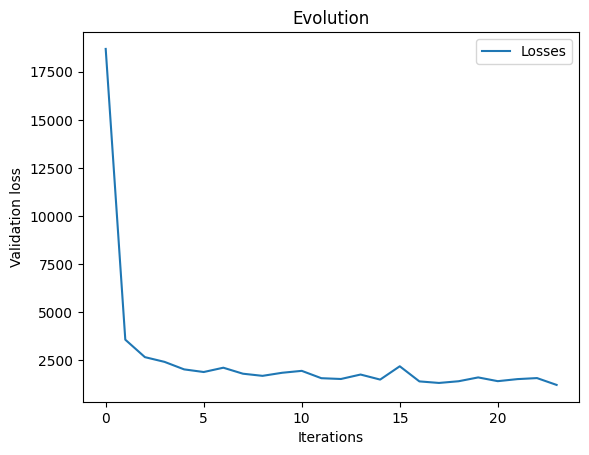

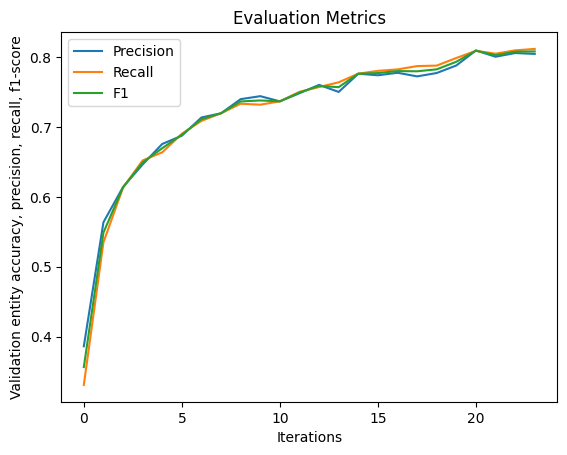

In [22]:
import matplotlib.pyplot as plt

# Plot losses
pl_losses = {'Losses': loss_scores}
for name, values in pl_losses.items():
  plt.plot(range(len(values)), values, label=name)
plt.title('Evolution')
plt.xlabel('Iterations')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

# Plot evaluation metrics
pl_metrics = {'Precision': precision_scores, 'Recall': recall_scores, 'F1': f1_scores}
for metric_name, metric_values in pl_metrics.items():
    plt.plot(range(len(metric_values)), metric_values, label=metric_name)

plt.title('Evaluation Metrics')
plt.xlabel('Iterations')
plt.ylabel('Validation entity accuracy, precision, recall, f1-score')
plt.legend()
plt.show()

# Test model

In [23]:
test_extracted_part = []

for i in range(len(test_df)):
  doc = nlp(test_df["text"][i])

  if len(doc.ents) != 0:
    for ent in doc.ents:
      if ent.label_ == test_df['label'][i]:
        entity = ent
    answer_start = test_df['text'][i].find(entity.text)
    answer_end = answer_start + len(entity.text)
    if answer_start == -1:
        test_extracted_part.append({'id': test_df['id'][i], 'text': test_df['text'][i], 'label': test_df['label'][i], 'extracted_part': {'text': [""], 'answer_start': [0], 'answer_end': [0]}})
    else:  
        test_extracted_part.append({'id': test_df['id'][i], 'text': test_df['text'][i], 'label': test_df['label'][i], 'extracted_part': {'text': [entity.text], 'answer_start': [answer_start], 'answer_end': [answer_end]}})
  else:
    test_extracted_part.append({'id': test_df['id'][i], 'text': test_df['text'][i], 'label': test_df['label'][i], 'extracted_part': {'text': [""], 'answer_start': [0], 'answer_end': [0]}})

In [24]:
test_extracted_part[:2]

[{'id': 762883279,
  'text': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Ф

In [25]:
doc = nlp(test_df["text"][0])
for ent in doc.ents:
    print(f'{ent.text}\n{ent.start_char}\n{ent.end_char}\n{ent.label_}')

Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).
1283
1393
обеспечение исполнения контракта


In [26]:
# Use displacy to visualize entities
displacy.render(doc, style='ent', jupyter=True)

# Save predictions and model

In [27]:
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [28]:
PRED_PATH = "./predictions/"

In [29]:
with open(PRED_PATH + 'predictions.json', 'w', encoding="utf-8") as f:
    json.dump(test_extracted_part, f, ensure_ascii=False, indent=2, cls=NpEncoder)

In [30]:
# Output directory
from pathlib import Path
output_dir=Path('./reference_ner_model')

# Saving the model to the output directory
if not output_dir.exists():
  output_dir.mkdir()
nlp.meta['name'] = 'ner'  # rename model
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

Saved model to reference_ner_model
